Code for examining how HMM performs under different perturbations to population activity. 

Tests recalibration performance in response to mean shifts, PD shifts

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from sklearn.linear_model import LinearRegression


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from HMM_matlab import hmmviterbi_vonmises, hmmdecode_vonmises
from hmm_utils import *
from simulation_matlab import *
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)


#### Distortion matrix analysis with channel sweep

- look at distortion matrix properties (axis-aligned shifts, rotations between X and Y subspaces) as a function of channel count


In [2]:
import multiprocessing, time



nUnits        = 1000
nSimSteps     = 100000
n_repeats     = 5
tuning_shift  = [0.3, 0]  # PD and mean
days_between  = 0
SNR           = 1


# gain sweep settings:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)
gainSteps   = 50000

#-------------------------------------------
n_cores         = multiprocessing.cpu_count() - 2
p               = multiprocessing.Pool(processes=n_cores)

session_scores  = np.zeros(( n_repeats,)) 
distortion_mats = np.zeros(( n_repeats, 2, 2)) 
 
eng             = matlab.engine.start_matlab()

nTrainingSteps = 10000

initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)
calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])


# Do a quick sweep of cursor gains to find the optimal one for this task:
possibleGain = np.linspace(0.5,2.5,10)
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, gainSteps, engine = eng)
    meanTTT[g] = np.mean(ttt)

beta   = possibleGain[np.argmin(meanTTT)]

print('Done')

Done


In [16]:
from simulation_matlab import simulateBCIFitts_parallel
import matlab

n = 10

eng.quit()
eng   = matlab.engine.start_matlab()
start = time.time()
for i in range(n):
    # simulate new days' data:
    cursorPos, _, decOut, _, targetPos, neural, _, ttt = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps, engine = eng) 

    PosErr     = targetPos - cursorPos  
    D_new      = np.linalg.lstsq(np.hstack([np.ones((neural.shape[0], 1)), neural]), PosErr, rcond = -1)[0]  # update previous decoder
    decVec_new = np.hstack([np.ones((neural.shape[0], 1)), neural]).dot(D_new)

    #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
    #This will restore the original optimal gain.
    TargDist   = np.linalg.norm(PosErr, axis = 1)
    TargDir    = PosErr / TargDist[:, np.newaxis]
    farIdx     = np.where(TargDist > 0.4)[0]
    projVec    = np.sum(np.multiply(decVec_new[farIdx, :], TargDir[farIdx, :]), axis = 1)
    D_new     /= np.mean(projVec)

    ttt_new    = simulateBCIFitts(initialTuning, D_new, alpha, beta, nDelaySteps, delT, nSimSteps, engine = eng)[-1] # simulate performance with recalibrated decoder
    np.mean(ttt_new)
    #getDistortionMatrix(D_new[1:, :], initialTuning[:, 1:])
print('Serial: ', np.round(time.time() - start, 3), ' seconds')
eng.quit()






Serial:  212.765  seconds


In [23]:
from simulation_matlab import generateDistortionMatrices_parallel

n = 10

eng.quit()
eng           = matlab.engine.start_matlab()
start         = time.time()
#distmats, ttt = generateDistortionMatrices_parallel([matlab.double(initialTuning.tolist())] * n, D, alpha, possibleGain[g], nDelaySteps, delT, gainSteps, engine = eng)
distmats, ttt = generateDistortionMatrices_parallel([initialTuning] * n, D, alpha, possibleGain[g], nDelaySteps, delT, gainSteps, engine = eng)
print('Parallelized: ', np.round(time.time() - start, 3), ' seconds')
eng.quit()

Got here!
Parallelized:  116.294  seconds


In [66]:
# general settings:
channel_sweep = [10, 50, 100, 500, 1000]
nSimSteps     = 100000
n_repeats     = 10
tuning_shift  = [0.92, 0.0191, 0.0]  # PD and mean
days_between  = 0
SNR           = 1


# gain sweep settings:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)
gainSteps   = 50000

#-----------------------------------------
session_scores  = np.zeros((len(channel_sweep), n_repeats,)) 
distortion_mats = np.zeros((len(channel_sweep), n_repeats, 2, 2)) 
 
eng             = matlab.engine.start_matlab()
for i, nUnits in enumerate(channel_sweep):
    nTrainingSteps = 10000

    initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)
    calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
    calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
    calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

    lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
    D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

    # Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    
    # Do a quick sweep of cursor gains to find the optimal one for this task:
    possibleGain = np.linspace(0.5,2.5,10)
    meanTTT      = np.zeros((len(possibleGain),))

    for g in range(len(possibleGain)):
        posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, gainSteps, engine = eng)
        meanTTT[g] = np.mean(ttt)
    beta          = possibleGain[np.argmin(meanTTT)]
    
    # send parameters over to matlab for fast parallelized code:
    tuning        = [simulateTuningShift(initialTuning, PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], mean_shift = tuning_shift[2], renormalize = False) for j in range(n_repeats)]
    distmats, ttt = generateDistortionMatrices_parallel(tuning, np.copy(D), alpha, beta, nDelaySteps, delT, gainSteps, engine = eng)

    session_scores[i, :]     = np.asarray([np.mean(times) for times in ttt])
    distortion_mats[i,:,:,:] = np.stack(distmats)

    print(nUnits, ' channel setting finished')
    print('----------------------------------')
    
eng.quit()

Got here!
10  channel setting finished
----------------------------------
Got here!
50  channel setting finished
----------------------------------
Got here!
100  channel setting finished
----------------------------------
Got here!
500  channel setting finished
----------------------------------
Got here!
1000  channel setting finished
----------------------------------


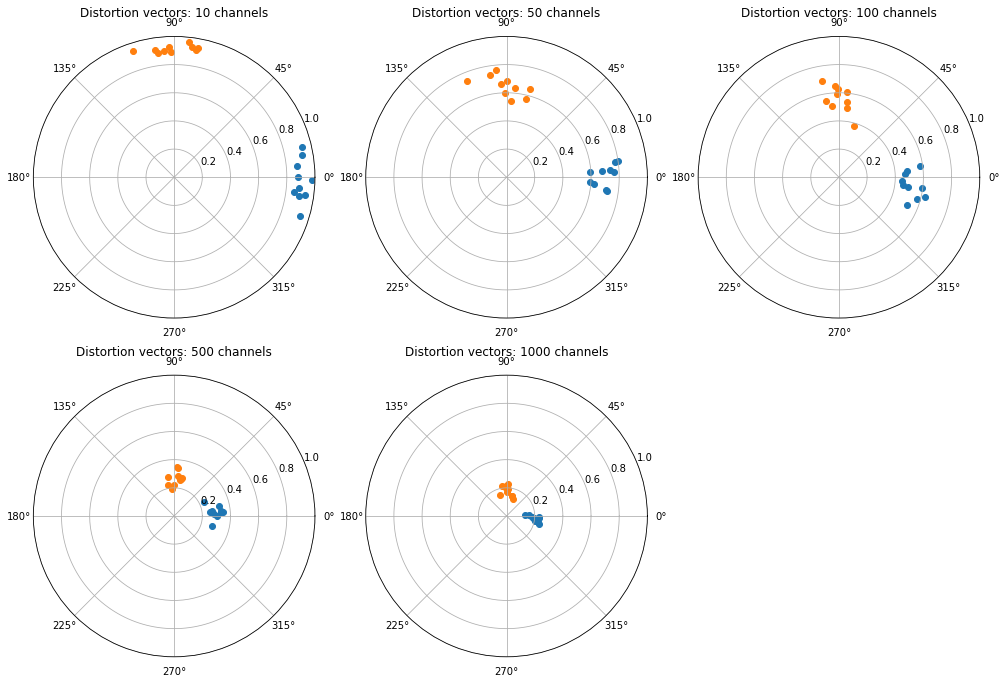

In [67]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt


figSize(14, 14)

labels = ['X distortion vectors', 'Y distortion vectors']

for i, nUnits in enumerate(channel_sweep):
    plt.subplot(3, 3, i + 1, projection='polar')
    for j in range(2):
        theta = np.arctan2(distortion_mats[i, :, 1, j], distortion_mats[i, :, 0, j])
        r     = np.linalg.norm(distortion_mats[i, :, :, j], axis = 1)
        plt.scatter(theta, r, )
        ax    = plt.gca()
        ax.set_rlim([0, 1])
    plt.title('Distortion vectors: ' + str(nUnits) + ' channels')
    
plt.tight_layout()